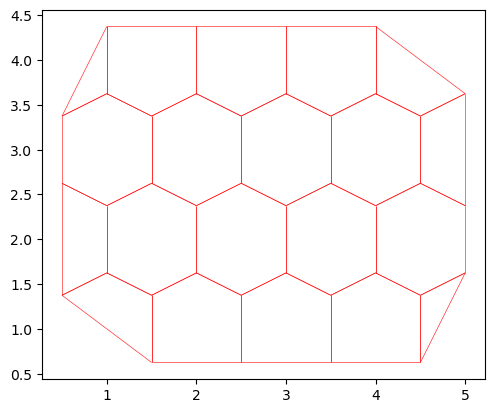

In [69]:
# Suppressing warnings resulting from downgrading pandas to 1.5.3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image


from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue.draw import sheet_view
from tyssue.generation import three_faces_sheet
from tyssue.draw.plt_draw import plot_forces

from tyssue.dynamics import PlanarModel

from tyssue.solvers.viscous import EulerSolver
from tyssue.draw.plt_draw import create_gif


geom  = SheetGeometry
model = PlanarModel

sheet = Sheet.planar_sheet_3d('planar', nx=6, ny=6, 
                             distx=1, disty=1)
sheet.sanitize(trim_borders=True, order_edges=True)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, edge = {'color':'red'})

# The  `history` object

The `History` class defines the object in charge of storing the evolving epithelium during the course of the simulation. It allows to access to different time points of a simulation from one unique epithelium. 

Most of the time, we use `HistoryHDF5` class, that writes each time step to a file, which can be useful for big files. It is also possible to read an hf5 file to analyze a simulation later. 


In the solver, we use the `history.record` method to store the epithelium.In the `create_gif` function, we use the `history.retrieve` method to get back the epithelium at a given time point. Please see the API for more details.



c:\Users\Thomas\OneDrive - University of Canterbury\Math\Cell Modelling


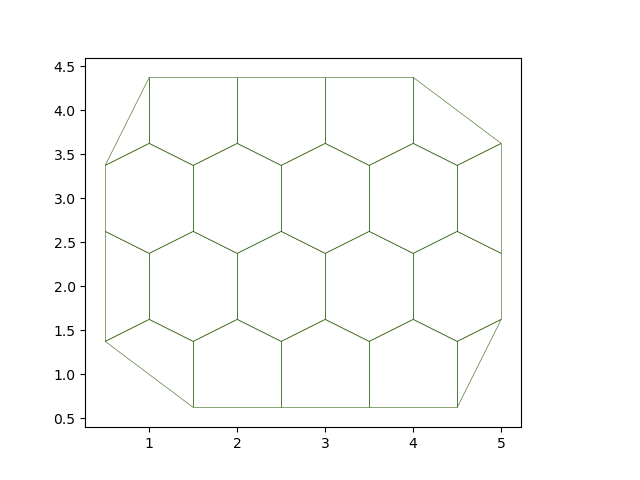

In [70]:
history = History(sheet, save_every=2, dt=1)
import os
print(os.getcwd())
for i in range(10):
    geom.scale(sheet, 1.02, list('xy'))
    geom.update_all(sheet)
    # record only every `save_every` time 
    history.record()

create_gif(history, 'simple_growth.gif', num_frames=len(history))


Image('simple_growth.gif')

`retrieve` returns an epithelium of the same type as the original:

In [71]:
type(history.retrieve(5))

tyssue.core.sheet.Sheet

Iterating over an `history` object yields a time and a `sheet` object:


In [72]:
for t, sheet in history:
    print(f"mean area at {t}: {sheet.face_df.area.mean():.3f}", )

mean area at 0.0: 0.781
mean area at 1.0: 0.813
mean area at 3.0: 0.880
mean area at 5.0: 0.952
mean area at 7.0: 1.031
mean area at 9.0: 1.116


The `vert_h`, `edge_h` and `face_h` DataFrames hold the history:

In [73]:
history.vert_h.head()

,vert,y,z,rho,is_active,x,basal_shift,height,time
0,0,2.625,0,0,1,0.5,4.0,-4.0,0.0
1,1,3.375,0,0,1,1.5,4.0,-4.0,0.0
2,2,2.625,0,0,1,2.5,4.0,-4.0,0.0
3,3,3.375,0,0,1,0.5,4.0,-4.0,0.0
4,4,3.625,0,0,1,1.0,4.0,-4.0,0.0


You can plot the evolution of a column vs time:

<Axes: xlabel='time'>

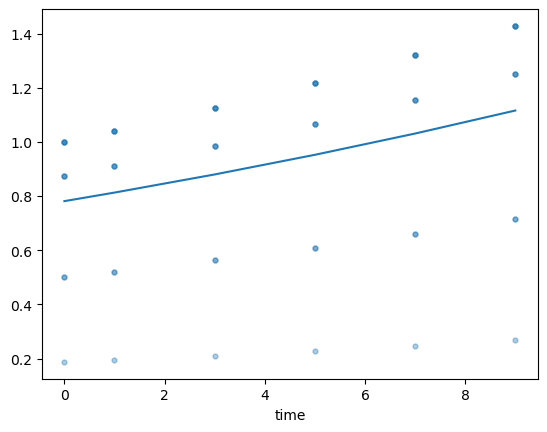

In [74]:
fig, ax = plt.subplots()

ax.scatter(history.face_h['time'], history.face_h['area'], alpha=0.2, s=12)

history.face_h.groupby('time').area.mean().plot(ax=ax)

# Quasistatic solver

A common way to describe an epithelium is with the **quasistatic approximation**: we assume that at any point in time, without exterior perturbation, the epithelium is at an **energy minimum**. For a given expression of the model's Hamiltonian, we thus search the position of the vertices corresponding to the minimum of energy.

### The Farhadifar model

A very common formulation for the epithelium mechanical energy was given in [Farhadifar et al. in 2007](https://doi.org/10.1016/j.cub.2007.11.049).

The energy is the sum of an area elasticity, a contractility and a line tension:
$$
E = \sum_\alpha \frac{K_A}{2}(A_\alpha - A_0)^2 + \sum_\alpha \Gamma P_\alpha^2 + \sum_{ij} \Lambda \ell_{ij} 
$$




This model has been predifined in tyssue as the default `PlanarModel`. We can use it in combination with a `Solver` object to find the energy minimum of our sheet.

To add the various columns in the dataframes (as we did above) we use a  **specification dictionnary** with the required parameters.

In [75]:
#from tyssue.config.dynamics import quasistatic_plane_spec
from tyssue.dynamics.planar_vertex_model import PlanarModel as smodel
from tyssue.solvers import QSSolver
from pprint import pprint

specs = {
    'edge': {
        'is_active': 1,
        'line_tension': 0.12,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0
    },
   'face': {
       'area_elasticity': 1.0,
       'contractility': 0.04,
       'is_alive': 1,
       'prefered_area': 1.0},
   'settings': {
       'grad_norm_factor': 1.0,
       'nrj_norm_factor': 1.0
   },
   'vert': {
       'is_active': 1
   }
}


# Update the specs (adds / changes the values in the dataframes' columns)
sheet.update_specs(specs)

pprint(specs)

{'edge': {'is_active': 1,
          'line_tension': 0.12,
          'ux': 0.0,
          'uy': 0.0,
          'uz': 0.0},
 'face': {'area_elasticity': 1.0,
          'contractility': 0.04,
          'is_alive': 1,
          'prefered_area': 1.0},
 'settings': {'grad_norm_factor': 1.0, 'nrj_norm_factor': 1.0},
 'vert': {'is_active': 1}}


In [76]:
E_t = smodel.compute_energy(sheet)
print("Total energy: ", E_t)

Total energy:  13.44300213965199


In [77]:
smodel.compute_gradient(sheet).head()

,gx,gy,gz
srce,,,
0,-4.934718e-01,-0.039296,0.0
1,0.000000e+00,0.163215,0.0
2,-9.020562e-16,-0.051386,0.0
3,-3.863108e-01,0.021599,0.0
4,-6.386835e-01,0.387129,0.0


The energy minimum is found with a _gradient descent_ strategy, the vertices are displaced in the direction opposite to the spatial derivative of the energy. Actually, this defines the **force** on the vertices.

The gradient descent algorithm is provided by scipy [`minimize`](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb) function, with the L-BFGSB method by default.




Successfull gradient descent?  True


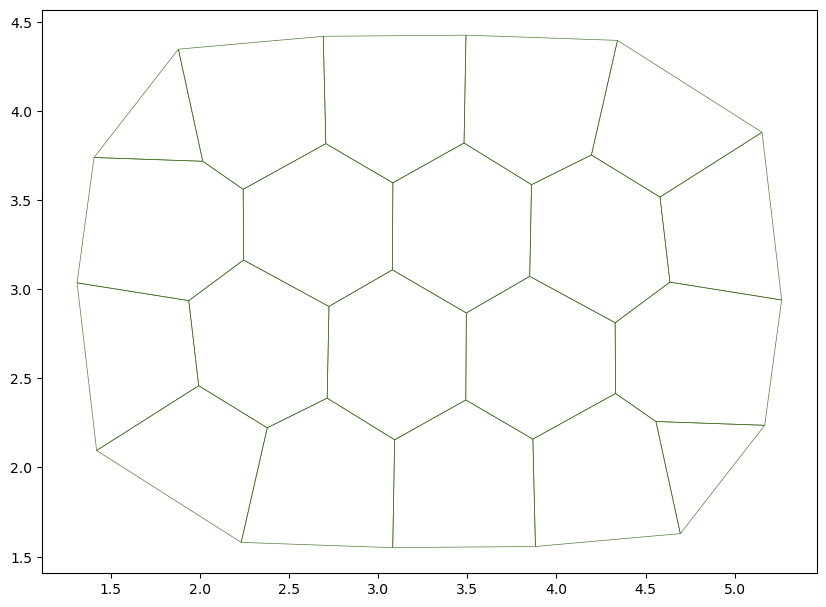

In [78]:
# Find energy minimum
solver = QSSolver()
res = solver.find_energy_min(sheet, geom, smodel)

print("Successfull gradient descent? ", res['success'])
fig, ax = sheet_view(sheet)

fig.set_size_inches(10, 10)
ax.set_aspect('equal')


Keyword arguments to `find_energy_min` method are passed to scipy's `minimize`, so it is possible for example to reduce the termination criteria:


In [79]:
sheet.face_df.loc[4, "prefered_area"] = 2.0

res = solver.find_energy_min(sheet, geom, smodel, options={"ftol": 1e-2})


The method returns the output of the minimize function.

In [80]:
print("Boolean for the convergence success: ")
print(res.success)

print("Number of function evaluations: ")

print(res.nfev) 

print("Information on the convergence: ")
print(res.message)


Boolean for the convergence success: 
True
Number of function evaluations: 
9
Information on the convergence: 
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


The  solver object also provides facilities to approximate the gradient (can be useful when debugging new effectors) and evaluate the error between the actual gradient and the approximate one.

In [81]:
print('Total gradient error: ')
solver.check_grad(sheet, geom, model)

Total gradient error: 


0.14544019296966426

In [82]:
app_grad = solver.approx_grad(sheet, geom, model)

In [83]:
app_grad = pd.DataFrame(app_grad.reshape((-1, 3)), columns=['gx', 'gy', 'gz'])

In [84]:
app_grad.head()

,gx,gy,gz
0,-0.000146,0.000178,0.0
1,-0.000592,0.000862,0.0
2,0.000279,-0.001306,0.0
3,-0.000259,0.000547,0.0
4,-0.000371,-0.000068,0.0


# Euler solver

This notebooks demonstrates usage of the time dependent solver `EulerSolver` in the simplest case where we solve
$$\eta_i \frac{d\mathbf{r}_i}{dt}  = \mathbf{F}_i = - \mathbf{\nabla}_i E$$

The model is used in the same way as the quasistatic solver.

## Simple forward Euler solver

$$\mathbf{r}_i(t+dt) = \mathbf{r}_i(t) + \frac{\mathbf{F}_i(t)}{\eta} dt$$


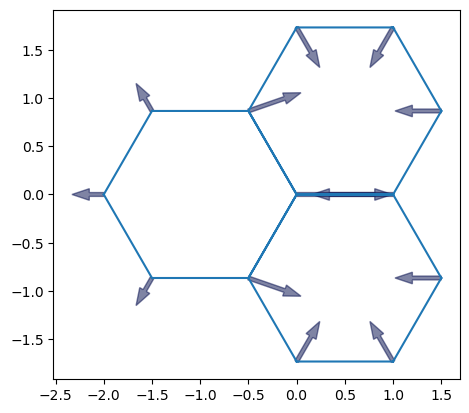

In [85]:
sheet = Sheet('3', *three_faces_sheet())
geom.update_all(sheet)
sheet.settings['threshold_length'] = 1e-3

sheet.update_specs(config.dynamics.quasistatic_plane_spec())
sheet.face_df["prefered_area"] = sheet.face_df["area"].mean()
history = History(sheet) #, extra_cols={"edge":["dx", "dy", "sx", "sy", "tx", "ty"]})

sheet.vert_df['viscosity'] = 1.0
sheet.edge_df.loc[[0, 17],  'line_tension'] *= 4
sheet.face_df.loc[1,  'prefered_area'] *= 1.2

fig, ax = plot_forces(sheet, geom, model, ['x', 'y'], 1)

Solver instanciation &mdash; contrary to the quasistatic solver, this solver needs the sheet, geometry and model at instanciation time:

In [86]:
solver = EulerSolver(
    sheet,
    geom,
    model,
    history=history,
    auto_reconnect=True)


The solver's `solve` method accepts a `on_topo_change` function as argument. This function is executed each time a topology change occurs. Here, we reste the line tension to its original value.

In [87]:
def on_topo_change(sheet):
    print('Topology changed!\n')
    print("reseting tension")
    sheet.edge_df["line_tension"] = sheet.specs["edge"]["line_tension"]


### Solving from $t = 0$ to $t = 15$

In [88]:
res = solver.solve(tf=15, dt=0.05, on_topo_change=on_topo_change,
                   topo_change_args=(solver.eptm,))

Topology changed!

reseting tension
Topology changed!

reseting tension


## Showing the results

In [89]:
create_gif(solver.history, "sheet3.gif", num_frames=120)

In [90]:
Image("sheet3.gif")


FileNotFoundError: No such file or directory: 'sheet3.gif'

FileNotFoundError: No such file or directory: 'sheet3.gif'

<IPython.core.display.Image object>